# Export Data for Web Application 

In [1]:
from cflp_function import cflp, plot_result, store_data_to_pickle, load_data_from_pickle, find_farm_not_in_solution_plant_in_solution, get_arc
import pandas as pd
import numpy as np
import pydeck as pdk
import geopandas as gpd
import os
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
from rasterio.plot import show

%matplotlib inline

In [4]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [2]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [51]:
# potential_digester_location = gpd.read_file(r'./raster/suitable_polygons_complete_gdf.shp')
# potential_digester_location.head()

In [12]:
# Define the capacities of digester
small_digester_capacity = 78480
medium_digester_capacity = 150560  # in tonne/yr
# large_digester_capacity = 200000  # in tonne/yr

# Define the costs of digester 
small_digester_cost = 209249
medium_digester_cost = 252616   # in euro CAPEX
# large_digester_cost = 12000000    # in euro CAPEX

In [4]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [13]:
# # Create mock digester capacity data 
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, small_digester_capacity, medium_digester_capacity, small_digester_capacity]
# potential_digester_location['capacity'] = small_digester_capacity
# # Create mock digester cost data (f_j)
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, small_digester_capacity, medium_digester_cost, small_digester_capacity]
# potential_digester_location['cost'] = small_digester_cost

## !!! Be careful here, max_capacity and fixed_cost should have keys that are the labels of Plant not the index, otherwise the model doesn't run!!!

In [14]:
# (q_j)
max_capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500}
# max_capacity = potential_digester_location.set_index('Label')['capacity'].to_dict()
# (f_j)
fixed_cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }
# fixed_cost = potential_digester_location.set_index('Label')['cost'].to_dict()

In [5]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [12]:
# farm = gpd.read_file(r"./farm_new.shp")
# farm.head()

In [58]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # set F
# Plant = potential_digester_location.Label.tolist() # set P
Plant = potential_digester_location.index.tolist()

In [59]:
# (p_i)
manure_production = farm['manure_t'].to_dict()  

# Define the total manure production by all farms (alpha)
total_manure = sum(manure_production[i] for i in Farm)

In [6]:
folder_path = 'app_data'

In [ ]:
# Export files

# List
store_data_to_pickle(Farm, folder_path, 'Farm_test.pickle') # set F
store_data_to_pickle(Plant, folder_path, 'Plant_test.pickle') # set P

# Dictionary 
store_data_to_pickle(manure_production, folder_path, 'manure_production_test.pickle') # p_i 
store_data_to_pickle(max_capacity, folder_path, 'max_capacity_test.pickle') # q_j
store_data_to_pickle(fixed_cost, folder_path, 'fixed_cost_test.pickle') # f_j

# C_ij 

# Float
store_data_to_pickle(total_manure, folder_path, 'total_manure_test.pickle') # alpha

In [7]:
Farm = load_data_from_pickle(folder_path, 'Farm_test.pickle')
        # set P     set of potential digester locations
Plant = load_data_from_pickle(folder_path, 'Plant_test.pickle')
    # Dictionary 
        # p_i       manure production of each i
manure_production = load_data_from_pickle(folder_path, 'manure_production_test.pickle')
        # q_j       max capacity of each j 
max_capacity = load_data_from_pickle(folder_path, 'max_capacity_test.pickle')
        # f_j       fixed cost of establishing each j
fixed_cost = load_data_from_pickle(folder_path, 'fixed_cost_test.pickle')        
        # C_ij      transportation matrix 
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost_test.pickle')
    # Float
        # alpha     total manure production
total_manure = load_data_from_pickle(folder_path, 'total_manure_test.pickle')
    # Float defined here
        # mu        manure utilization target 

## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [8]:
# Define manure use goal (mu)
target = 0.2

In [9]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/243ccdf8bbb048c69d9438f7cc867e3c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/243ccdf8bbb048c69d9438f7cc867e3c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 141054 - 0.00 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 23 integers unsatisfied sum - 4.82478
Cbc

In [18]:
# # Check if the opened plants are under-utilized
# total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

# potential_digester_location['allocated_manure'] = total_sum_list

# # Find the percentage of plant's capacity that is utilized
# potential_digester_location['underutilized'] = 0
# mask = potential_digester_location['allocated_manure'] > 0
# potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
# potential_digester_location

In [10]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


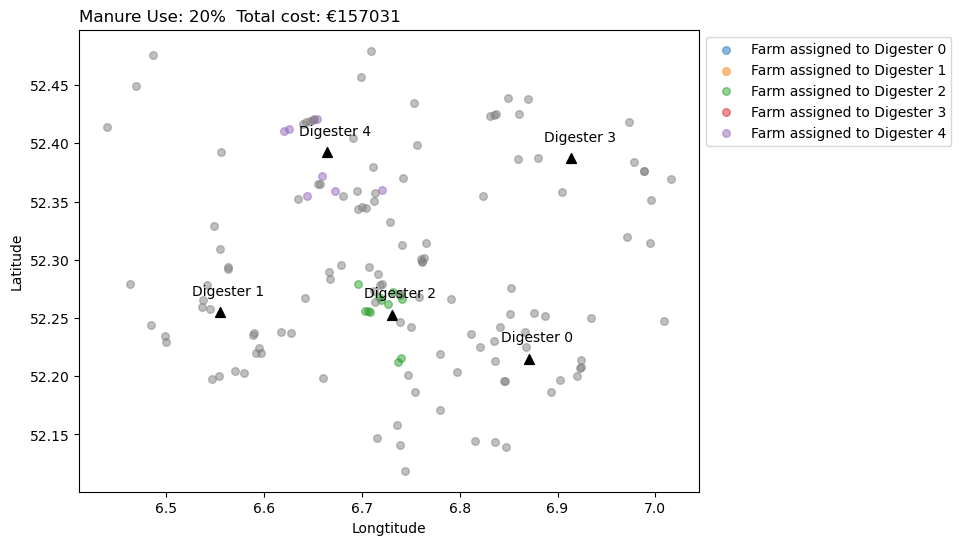

In [11]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [16]:
for key, value in assignment_decision.items():
    print(f"{key}: {value}")

0: []
1: []
2: [24, 40, 41, 48, 76, 77, 92, 123, 124, 125, 133, 137]
3: []
4: [66, 69, 70, 111, 113, 114, 121, 128]


## Plot with PyDeck

In [43]:
os.environ["MAPBOX_API_KEY"]="sk.eyJ1Ijoid2VueXVjaGVuIiwiYSI6ImNscDZxZ2hpZzF0ejYyaXBicWs0YWZzb2kifQ.ReihW6LnhBUycKmcX_OIYQ"
MAPBOX_API_KEY = os.environ["MAPBOX_API_KEY"]

In [19]:
import random
# Create a color mapping for digesters 
color_mapping = {label: [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for label in assignment_decision.keys()}

In [21]:
digester_df, assigned_farms_df, unassigned_farms_df = get_plot_variables(assignment_decision, potential_digester_location, farm, color_mapping)

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_57414/3071834205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})


In [22]:
# Create a Pydeck layer for digesters
digesters_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=digester_df,
    get_position=['x', 'y'],
    get_radius=1000,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for assigned farms
assigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=assigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for unassigned farms
unassigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=unassigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color=[128, 128, 128],
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck deck
deck = pdk.Deck(
    layers=[digesters_layer, assigned_farms_layer, unassigned_farms_layer],
    initial_view_state=pdk.ViewState(
        latitude=potential_digester_location['y'].mean(),
        longitude=potential_digester_location['x'].mean(),
        zoom=8,
        pitch=0
    )
)

# Show the Pydeck Deck
deck.to_html("deck_trial_2.html")

In [44]:
# # Import Mapbox API Key from environment
MAPBOX_API_KEY = os.environ["MAPBOX_API_KEY"]
 
# # AWS Open Data Terrain Tiles
# TERRAIN_IMAGE = "https://s3.amazonaws.com/elevation-tiles-prod/terrarium/{z}/{x}/{y}.png"
 
# # Define how to parse elevation tiles
# ELEVATION_DECODER = {"rScaler": 256, "gScaler": 1, "bScaler": 1 / 256, "offset": -32768}
 
# SURFACE_IMAGE = f"https://api.mapbox.com/v4/mapbox.satellite/{{z}}/{{x}}/{{y}}@2x.png?access_token={MAPBOX_API_KEY}"
 
# terrain_layer = pdk.Layer(
#     "TerrainLayer", elevation_decoder=ELEVATION_DECODER, texture=SURFACE_IMAGE, elevation_data=TERRAIN_IMAGE
# )
 
# view_state = pdk.ViewState(latitude=46.24, longitude=-122.18, zoom=11.5, bearing=140, pitch=60)
 
# r = pdk.Deck(terrain_layer, initial_view_state=view_state)

# # Show the Pydeck Deck
# r.to_html("terrain_layer.html")

In [14]:
arc_layer_df = get_arc(assignment_decision, potential_digester_location, farm)

In [18]:
import leafmap
# raster_path = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_4326.tif'

raster_path = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_complete_3857.tif'

In [19]:
m = leafmap.Map()
m.add_raster(raster_path, cmap="viridis", layer_name="Raster Layer")
m

In [10]:
raster_file = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_4326.tif'

#'/Users/wenyuc/Desktop/UT/data/raster/fuzzy_and_complete_1_4326.tif'

with rasterio.open(raster_file) as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)

Band1 has shape (4356, 5057)
lons shape (4356, 5057)


In [12]:
# Flatten the arrays and create a DataFrame
df = pd.DataFrame({
    'Latitude': lats.flatten(),
    'Longitude': lons.flatten(),
    'Value': band1.flatten()  # You might want to adjust this based on your raster data structure
})

# Optionally, you can filter out no-data values
df = df[df['Value'] != src.nodatavals[0]]

# Display the resulting DataFrame
print(df.head())

         Latitude  Longitude     Value
184373  52.494923   6.669241  0.254187
184374  52.494923   6.669390  0.255613
189428  52.494835   6.668943  0.252816
189429  52.494835   6.669092  0.254251
189430  52.494835   6.669241  0.255684


In [50]:
COLOR_BREWER_BLUE_SCALE = [
    [240, 249, 232],
    [204, 235, 197],
    [168, 221, 181],
    [123, 204, 196],
    [67, 162, 202],
    [8, 104, 172],
]
# Set the view
view_state = pdk.ViewState(
    longitude=df['Longitude'].mean(),
    latitude=df['Latitude'].mean(),
    zoom=10,
    pitch=0)

layer = pdk.Layer(
    "HeatmapLayer",
    data=df,
    opacity=0.9,
    get_position=["Longitude", "Latitude"],
    aggregation=pdk.types.String("MEAN"),
    get_weight="Value",
    pickable=True, tooltip={"text": "Value: {Value}"}
)

In [6]:
# r = pdk.Deck(
#     layers=[layer],
#     initial_view_state=view_state
# )

# r.to_html("heatmap_layer.html")

In [13]:
# Define a layer to display on a map
layer = pdk.Layer(
    "ScreenGridLayer",
    df,
    pickable=False,
    opacity=0.7,
    cell_size_pixels=20,
    color_range=[
        [0, 25, 0, 25],
        [0, 85, 0, 85],
        [0, 127, 0, 127],
        [0, 170, 0, 170],
        [0, 190, 0, 190],
        [0, 255, 0, 255],
    ],
    get_position=["Longitude", "Latitude"],
    get_weight="Value",
)
# Set the viewport location
view_state = pdk.ViewState(longitude=df['Longitude'].mean(), latitude=df['Latitude'].mean(), zoom=10, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("screengrid_layer.html")